In [1]:
import cv2 as cv
import numpy as np
import seaborn as sns

font = cv.FONT_HERSHEY_SIMPLEX
org = (50, 50)
fontScale = 1
color = (255, 255, 255)
thickness = 2

kernel = np.ones((3,3),np.uint8)


In [2]:
def compute_lines(line: np.array):
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 480*(-b))
    y1 = int(y0 + 600*(a))
    x2 = int(x0 - 480*(-b))
    y2 = int(y0 - 600*(a))
    return x1, y1, x2, y2

In [3]:
def calibrate_threshold(cap: cv.VideoCapture) -> int:
    calibrating = True
    threshold = 127
    
    while calibrating:
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        _, thresh = cv.threshold(imgray, threshold, 100, cv.THRESH_BINARY)

        pressed_key = cv.waitKey(1)
        if pressed_key == ord('a'):
            threshold = min(255, threshold + 10)
        elif pressed_key == ord('s'):
            print('hey')
            threshold = max(0, threshold - 10)
        elif pressed_key == ord(' '):
            calibrating = False

        thresh = cv.putText(
            thresh, str(threshold), org, font, 
                   fontScale, (255, 255, 255), thickness, cv.LINE_AA)
        # print(threshold)
        cv.imshow('frame', thresh)

    return threshold

In [4]:
multiplier = 0.05

def trackbar_callback(value):
    global multiplier
    multiplier = value * 1e-2
    print(multiplier)

def calibrate_camera(cap: cv.VideoCapture, threshold: int) -> np.array:
    calibrating = True

    width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)


    image_series = []

    cv.namedWindow('frame')

    cv.createTrackbar('Threshold', 'frame', 1, 20, trackbar_callback)

    while calibrating:
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        processed_image = process_image(frame)
        if len(image_series) > 10:
            image_series[:-1] = image_series[1:]
            image_series[-1] = processed_image
        else:
            image_series.append(processed_image)
            
        image_median = np.median(image_series, axis=0).astype("uint8")
        image_median = cv.medianBlur(image_median, 3)

        try:
            print(multiplier)
            polygon_contour = get_object_polygon_contour(image_median, multiplier)
            cv.drawContours(frame, [polygon_contour], -1, (0,255,0), 2)
        except Exception as e:
            print('nenhum contorno', e)


        pressed_key = cv.waitKey(1)
        if pressed_key == ord(' '):
            calibrating = False
        # if pressed_key == ord('a'):
        #     multiplier = min(1, multiplier + 0.01)
        # elif pressed_key == ord('s'):
        #     multiplier = max(0, multiplier - 0.01)
        # elif pressed_key == ord(' '):
        #     calibrating = False


        frame = cv.putText(
            frame, str(multiplier), org, font, 
                   fontScale, (255, 255, 255), thickness, cv.LINE_AA)

        cv.imshow('frame', frame)

    return polygon_contour, multiplier

In [5]:
def get_object_polygon_contour(image_median, multiplier: float = 0.01):
    try:
        contours,hierarchy = cv.findContours(image_median, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        area_list = np.array([cv.contourArea(contour) for contour in contours])
        object_countour_index = np.argmax(area_list)
        contour = contours[object_countour_index]
        epsilon = multiplier * cv.arcLength(contour,True)
        approx = cv.approxPolyDP(contour,epsilon,True)
    except Exception as e:
        print('nenhum contorno', e)
        return []
    return approx

In [6]:
def process_image(image):
    imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(imgray, threshold, 255, cv.THRESH_BINARY_INV)
    processed_image = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    processed_image = cv.morphologyEx(processed_image, cv.MORPH_DILATE, kernel, iterations=3)
    return processed_image

In [7]:
cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

main_loop = True

threshold = calibrate_threshold(cap)
original_polygon, multiplier = calibrate_camera(cap, threshold)
original_moment = cv.moments(original_polygon)
original_x_centroid = int(original_moment['m10']/original_moment['m00'])

TOLERANCE = 50

width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)

image_series = []

while main_loop:
    ret, frame = cap.read()

    processed_image = process_image(frame)

    if len(image_series) > 40:
        image_series[:-1] = image_series[1:]
        image_series[-1] = processed_image
    else:
        image_series.append(processed_image)
    image_median = np.median(image_series, axis=0).astype("uint8")
    image_median = cv.medianBlur(image_median, 3)

    
    cv.drawContours(frame, [original_polygon], -1, (0, 0, 255), 2)
    try:
        approx = get_object_polygon_contour(image_median, multiplier)
        live_moment = cv.moments(approx)
        live_x_centroid = int(live_moment['m10']/live_moment['m00'])
        cv.drawContours(frame, [approx], -1, (0,255,0), 2)
        cv.line(frame, (live_x_centroid, int(height/2)), (original_x_centroid, int(height/2)), (255, 0, 0), 2)
        # cv.fillPoly(frame,pts=[approx],color=(255,255,255))
    except Exception as e:
        print('nenhum contorno', e)

    centroid_difference = original_x_centroid - live_x_centroid
    if centroid_difference > TOLERANCE:
        actor_response = 'Esquerda'
    elif centroid_difference < -TOLERANCE: 
        actor_response = 'Direita'
    else:
        actor_response = ' '


    frame = cv.putText(
            frame, str(np.round(centroid_difference, 2)), org, font, 
                   fontScale, (0, 0, 0), thickness, cv.LINE_AA)
    frame = cv.putText(
            frame, actor_response, (50, 150), font, 
                   fontScale, (0, 0, 0), thickness, cv.LINE_AA)
    
    cv.imshow('frame', frame)

    if cv.waitKey(1) == ord('q'):
        main_loop = False
 
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

hey
hey
hey
hey
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01


In [8]:
ax = sns.lineplot(
    [
        # belt_diff_series[50:],
        window_median_series
    ], 
    markers=False
)
ax.axhline(y=TOLERANCE, linewidth=2, color='orange', ls=':')
ax.axhline(y=-TOLERANCE, linewidth=2, color='orange', ls=':')

NameError: name 'window_median_series' is not defined

<Axes: >

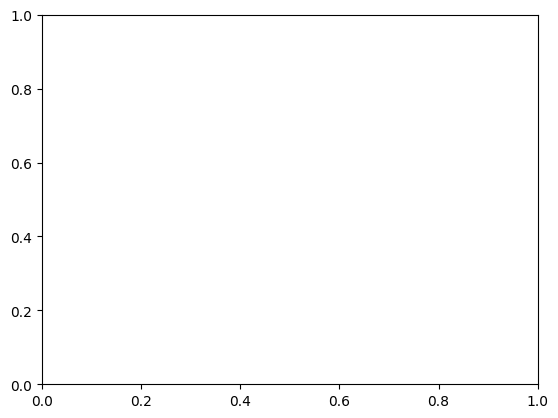

In [ ]:
sns.lineplot()

<Axes: >

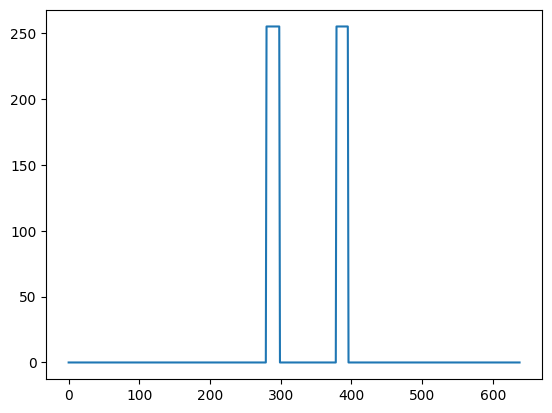

In [ ]:
arr = np.diff(np.sum(255 - thresh, axis=0))
arr[arr > 255] = 255
sns.lineplot(arr)

<Axes: >

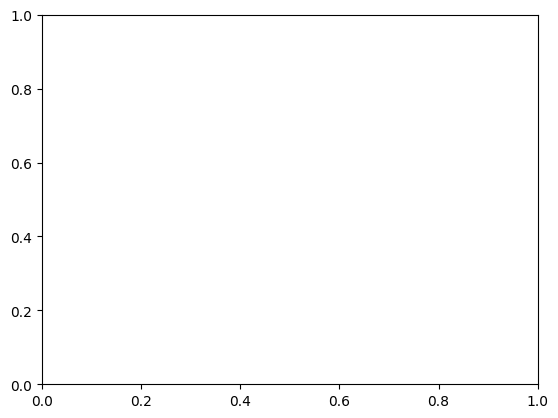

In [ ]:
sns.lineplot()

In [ ]:
ret, frame = cap.read()
edges = cv.Canny(frame, 200,150)

In [ ]:
plt.imshow(edges)

NameError: name 'plt' is not defined

In [ ]:
lines = cv.HoughLines(edges,2, np.pi/180,260)

try:
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv.line(frame,(x1,y1),(x2,y2),(0,0,255),2)

except TypeError as e:
    print('Nao foi possivel identificar linhas')

In [ ]:
imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [ ]:
cv.drawContours(frame, contours, -1, (0,255,0), 3)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

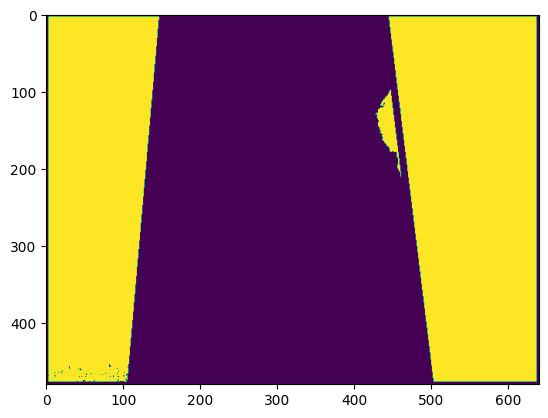

In [ ]:
imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 180, 200, 0)
plt.imshow(thresh)

In [ ]:

    
    ret, frame = cap.read()
 
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    edges = cv.Canny(frame,100,200)
    # Our operations on the frame come here
    # gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Display the resulting frame

    lines = cv.HoughLines(edges,2, np.pi/180,260)

    try:
        for line in lines:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv.line(frame,(x1,y1),(x2,y2),(0,0,255),2)

    except TypeError as e:
        print('Nao foi possivel identificar linhas')

    cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('q'):
        break
 
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()